## E-tivity   - Binary Logistic regression continue - Task B

The goal of this second task is to extend your code for Task A by implementing and using/testing **two** additional optimization methods to train a logistic-classifier.
Again you are only allowed to use numpy and autograd (or Julia basic code and Zygote.jl).  You have to use your logistic regression class from e-tivity 1 to apply and test them.

You must implement/use **two** algorithms from this list:
1. a local_descent that uses Quadratic_Fit_Search (Book sec 3.5) instead of golden_section_search for the line_search step
2. a local_descent that uses backtracking_line_search (Book algorithm 4.2) instead of golden_section_search for the line_search step
3. a local_descent that uses strong_backtracking_line_search (Book algorithm 4.3) instead of golden_section_search for the line_search step
4. a ConjugateGradientDescent method (Book algorithm 5.2), you can use any line_search implementation.
5. Adagrad (Book algorithm 5.5)
6. RMSProp (Book algorithm 5.6)
7. Adadelta (Book algorithm 5.7)
8. Adam     (Book algorithm 5.8)
9. BFGS (Book algorithm 6.4)
10. L-BFGS (Book algorithm 6.5)

If you are working in Python you need to translate the algorithms from Julia to Python, instead if you are working in Julia you just need to integrate those algorithms with your logistic_regression class.

**Your notebook must include**:
1. a theoretical part that explains  the details of the algorithms you implemented. You can summarize the description you find in the Book but we will  encourage you to search additional resources that can give you more insight about the algorithms (for instance concerning how they behave in presence of local minima and saddle points, when appropriate)
2. the implementation of the algorithm (either in Python or in Julia)
3. You have to evaluate the performance of the two optimization algorithms (stand-alone codes) by testing them on two test functions from the Book/Test Functions, (Appendix B). Can they find the global optimum?
4. You have to use the two algorithms for logistic_regression fitting and comparing the results with the implementation in Task A. Also in this case, you have to verify that the input-output behavior of the logistic_regression algorithm is correct. You should use the methods you devised during *Task A/Respond and Reflect*


**Submission:** you must submit a Python notebook in Sulis. In this case, you **must include** in your notebook the tests you performed to check the input-output behavior of your classifier. **This is an individual assignment and so you are supposed to work without help from your peers**.

**Please use the following filename `TaskB_Yourfullname.ipynb` (or a zip file) and add your full name and student number at the top of your submitted notebook.**


To select the two algorithms you have to implement, run the following code by replacing the value of the string `name` with your full name.


In [1]:
import random
import numpy as np
List = ['Quadratic_Fit_Search','backtracking_line_search','strong_backtracking_line_search',
        'ConjugateGradientDescent','Adagrad','RMSProp','Adadelta','Adam',
       'BFGS','L-BFGS']

name="Mark OBrien"

random.seed(name)
print(random.sample(List,k=2))

['Adam', 'Adagrad']


In [2]:
# Re-Implement Task A from Feedback
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from math import sqrt

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# Load Datasets

(100, 1)
(100, 4)


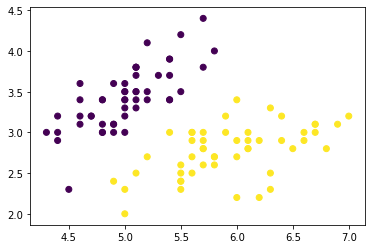

In [3]:
# Load Iris Dataset
X, y = load_iris(return_X_y=True)
ind = np.where((y==0) | (y==1))[0] # we only have two classes now
X = X[ind,:]
y = y[ind]

y = np.reshape(y, (y.shape[0], 1))
print(y.shape)
print(X.shape)

_ = plt.scatter(X[:, 0], X[:, 1], c=y.flatten() )

X = np.hstack([np.ones((X.shape[0], 1)), X]) # bias

(100, 1)
(100, 13)


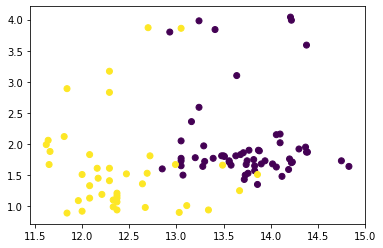

In [4]:
# Load Wine Dataset
X_w, y_w = load_wine(return_X_y=True)
ind = np.where((y==0) | (y==1))[0] # we only have two classes now
X_w = X_w[ind,:]
y_w = y_w[ind]

y_w = np.reshape(y_w, (y_w.shape[0], 1))
print(y_w.shape)
print(X_w.shape)

_ = plt.scatter(X_w[:, 0], X_w[:, 1], c=y_w.flatten() )

X_w = np.hstack([np.ones((X_w.shape[0], 1)), X_w]) # bias

(100, 1)
(100, 30)


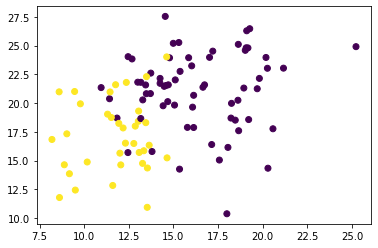

In [5]:
# Load Brest Cancer Dataset
X_b, y_b = load_breast_cancer(return_X_y=True)
ind = np.where((y==0) | (y==1))[0] # we only have two classes now
X_b = X_b[ind,:]
y_b = y_b[ind]

y_b = np.reshape(y_b, (y_b.shape[0], 1))
print(y_b.shape)
print(X_b.shape)

_ = plt.scatter(X_b[:, 0], X_b[:, 1], c=y_b.flatten() )

X_b = np.hstack([np.ones((X_b.shape[0], 1)), X_b]) # bias

# Algorithm Implementations
The following sections will implemented the algorithms and functions required to evaluate Local Descent, Addgrad and Adam optimizers. 

## Logistic Regression
Custom implementation using cross entropy as cost function. Allows input of multiple optimization methods for evaluation

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class Generic_LogisticRegression():
    def __init__(self, θ, sigmoid, α=1.0):
        self.θ = θ #initial value of the parameter
        self.sigmoid = sigmoid #a sigmoid function that squezes the input into [0,1]
        self.α = α #reguralisation parameter
        self.cost_agg = []
        
    
    def get_params(self, deep=True):
        '''Required method to be considered Sklearn compatible'''
        return {"θ": self.θ, "sigmoid": self.sigmoid, "α": self.α}
    
    
    def __agg_cost(self, cost):
        '''Helper function to aggregate the cost over training'''

        if (type(cost) is not np.numpy_boxes.ArrayBox):
            self.cost_agg.append(cost)
    
    
    def __prob(self, x, theta):
        '''Helper that uses sigmoid fucntion to squash the result between zero and one'''
        return self.sigmoid(np.dot(x, theta))
    
    
    def fit(self, x, y, method, params):  
        def cost_i(θ):
            h = self.__prob(x, θ)
            m = x.shape[0]
            # Cross Entropy function
            cost = -(1.0/m) * (np.dot(y.T, np.log(h)) + np.dot((1-y.T), np.log(1-h))) + (self.α * np.sum(θ**2))
            self.__agg_cost(cost[0][0])
            return cost
        
        # Function to calculate gradient
        gradcost = grad(cost_i)
        
        # Updated value for θ
        θ = method(self.θ, cost_i, gradcost, steps=params['steps'], α=params['α'], ϵ_x=params['ϵ_x'], ϵ_d=params['ϵ_d'], plotting=False)
        self.θ = θ[-1]
    
    
    def predict_proba(self, x):
        return self.__prob(x, self.θ)
    
    
    def predict(self, x, th=0.5):
        return np.where(self.predict_proba(x) >= th, 1, 0)  

## Evaluate Algorithm Performance

In [7]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return np.sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0,axis=0)

def rosen_der(x):
    """Derivative of generalized Rosen function."""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

def plot_rosen(algo, steps):
    xt = np.linspace(0, 2, 100)
    yt = np.linspace(0, 2, 100)
    Xt, Yt = np.meshgrid(xt, yt)
    Z = rosen(np.vstack([Xt.ravel(), Yt.ravel()])).reshape((100,100))

    x0 = np.array([[-0.2,-0.2]]).T
    output = algo(x0, rosen, rosen_der,  steps=steps, α=0.1)
    output = np.hstack(output)

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.contour(xt, yt, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 2, 10)], cmap='jet')
    plt.text(1, 1, 'x', va='center', ha='center', color='green', fontsize=20);
    plt.plot(output.T[:, 0], output.T[:, 1], '-ro')
    plt.subplot(122)
    plt.semilogy(range(output.shape[1]), rosen(output));
    
def booth(x):
    result = np.sum((x[:-1] + 2*x[1:] -7)**2.0 +(2*x[:-1] + x[1:] -5)**2.0,axis=0)
    return result

def booth_der(x):
    return grad(booth)

def plot_booth(algo, steps):
    xt = np.linspace(-10, 10, 100)
    yt = np.linspace(-10, 10, 100)
    Xt, Yt = np.meshgrid(xt, yt)
    Z = booth(np.vstack([Xt.ravel(), Yt.ravel()])).reshape((100,100))
    
    x0 = np.array([[4,-4.1]]).T
    output = algo(x0, booth, grad(booth), steps=steps, α=0.1)
    output = np.hstack(output)

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.contour(xt, yt, Z, np.arange(10)**5, cmap='jet')
    plt.plot(output.T[:, 0], output.T[:, 1], '-ro')
    plt.subplot(122)
    plt.semilogy(range(output.shape[1]), booth(output));

## Test Helper

In [8]:
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve

class Validate_Model():
    '''
    Organisation of different methods by which we can test and validate our optimisation algorithms
    '''
    
    def __init__(self, model, X, y, func, params):
        self.model = model
        self.X = X
        self.y = y
        self.func = func
        self.params = params
        self.y_pred = None
    
    
    def fit(self):
        self.model.fit(self.X, self.y, self.func, self.params)
        self.y_pred = self.model.predict(self.X)
        
    
    def log_loss(self):
        loss = metrics.log_loss(self.y, self.y_pred)
        return loss
    
    
    def accuracy(self):
        acc = metrics.accuracy_score(self.y, self.y_pred)
        clf = LogisticRegression(random_state=0, solver='liblinear').fit(self.X, self.y)
        skl = clf.score(self.X, self.y)
        return f'Accuracy {acc} compared to Sklearn {skl}'  
    
    
    def confusion_matrix(self):
        cnf_matrix = metrics.confusion_matrix(self.y, self.y_pred)
        return cnf_matrix
        
    
    def classification_report(self):
        report = classification_report(self.y, self.y_pred);
        return report
     
    def cv(self):
        mean_fpr = np.linspace(start=0, stop=1, num=100)
        GLR_accuracies = np.array([])
        GLR_f1_scores = np.array([])
        GLR_tprs = np.empty(shape=[0,mean_fpr.shape[0]])
        GLR_aucs = np.array([])

        # cv is a k-fold cross-valiatidation object
        cv = StratifiedKFold(n_splits=10)

        # Loop to run the K-fold test and record sklearn metric scores each time
        for train, test in cv.split(self.X, self.y):
            # train the classifier and compute the classes for the test set
            θ_init = np.zeros((self.X.shape[1],1))
            GLR = Generic_LogisticRegression(θ_init, sigmoid, 0.01)
            _model = GLR.fit(self.X, self.y, self.func, self.params)
            _probabilities = GLR.predict_proba(self.X[test])
            _predictions = GLR.predict(self.X[test])

            # compute accuracy
            GLR_accuracies = np.append(GLR_accuracies, accuracy_score(self.y[test], _predictions))

            # compute f1 score
            GLR_f1_scores = np.append(GLR_f1_scores, f1_score(self.y[test], _predictions))

            # compute fpr and tpr values for various thresholds 
            # by comparing the true target values to the predicted probabilities for class 1
            _fpr, _tpr, _thresholds = roc_curve(y_true = self.y[test], y_score = _probabilities[:, 0])

            # compute true positive rates for the values in the array mean_fpr
            _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
            GLR_tprs = np.concatenate((GLR_tprs, _tpr_transformed), axis=0)

            # compute the area under the curve
            GLR_aucs = np.append(GLR_aucs, auc(_fpr, _tpr))
            
            return GLR_accuracies, GLR_f1_scores, GLR_tprs, GLR_aucs
    
    def plot_roc_cv_folds(self, mean_fpr, tprs, aucs, classifier_name):
    
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

        for i in range(0, aucs.shape[0]):
            plt.plot(mean_fpr, tprs[i,:], lw=1, alpha=0.3,label='fold %d (AUC = %0.2f)' % (i, aucs[i]))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curves for %d cross-validation folds: %s' % (aucs.shape[0], classifier_name))
        plt.legend(loc="lower right")
        plt.show()
    
    def plot_roc_mean(self, mean_fpr, tprs, aucs, classifier_name):
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        # ROC curve - mean curve for all cross-validation runs
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        # colour in grey the area of the standard deviation from the mean tpr
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Mean ROC curve for all cross-validation runs: ' + classifier_name)
        plt.legend(loc="lower right")
        plt.show()

In [9]:
def evaluate_lr(validate):
    
    # Log Loss
    print(f'The algorithms output for log loss is {validate.log_loss()}')

    # Accuracy
    print(validate.accuracy())

    # Classification Report
    print(validate.classification_report())

    # Confusion Matrix
    print('Confusion Matrix Values')
    print(validate.confusion_matrix())

    print('Stratified KFold Cross Validation')
    print('AUC Analysis')
    mean_fpr = np.linspace(start=0, stop=1, num=100)
    GLR_accuracies, GLR_f1_scores, GLR_tprs, GLR_aucs = validate.cv()
    validate.plot_roc_cv_folds(mean_fpr, GLR_tprs, GLR_aucs, 'GLR')

    validate.plot_roc_mean(mean_fpr, GLR_tprs, GLR_aucs, 'GLR')

## Local Descent
The following functions provide implementations of Local Descent with Line Search optimization algorithm

In [10]:
# Golden Retio
ϕ = (1 + sqrt(5))/2

def bracket_minimum(f, x=0, s=1e-2, k=2.0): #From the Book, pag.36
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a<c else (c, a)        
        a, ya, b, yb = b, yb, c, yc
        s *= k
        
def golden_section_search(f, a, b, max_iter, plotting=True): #from the Book pag.41
    a0 =a
    b0=b
    ρ = φ-1
    d = ρ * b + (1 - ρ)*a
    yd = f(d)
    for i in range(max_iter-1):
        c = ρ*a + (1 - ρ)*b
        yc = f(c)
        if yc < yd:
            b, d, yd = d, c, yc
        else:
            a, b = b, c   
        if plotting==True:
            plt.figure()
            xx = np.linspace(a0,b0,100)
            plt.plot(xx,f(xx))
            plt.scatter(np.array([a,b]),np.array([a,b])*0)
            plt.scatter(np.array([a,b]),np.array([f(a),f(b)]))

    return (a, b) if a<b else (b, a)

def line_search(f, x, d, ϵ_x=0.0001, ϵ_d=0.0001):
    term = False
    if np.linalg.norm(d) < ϵ_d:
        term = True
        return x
    objective = lambda α : f(x + α*d)
    a, b = bracket_minimum(objective)
    a, b = golden_section_search(objective, a, b, max_iter = 5, plotting=False)
    α = (a+b)/2
    if np.linalg.norm(x+a*d-x)<ϵ_x:
        term = True
    return x + α*d, term

def local_descent(β,cost, gradient, steps=1, α=None, ϵ_x=0.0001, ϵ_d=0.0001, plotting=False):
    Tmp = [β]
    for iteration in range(steps):
        d = gradient(β)
        d = -d/np.linalg.norm(d)
        β, term = line_search(cost, β, d, ϵ_x=ϵ_x, ϵ_d=ϵ_d)
        if term == True:
            break
        Tmp.append(β)
    return Tmp

## Measure Optimizer Performance

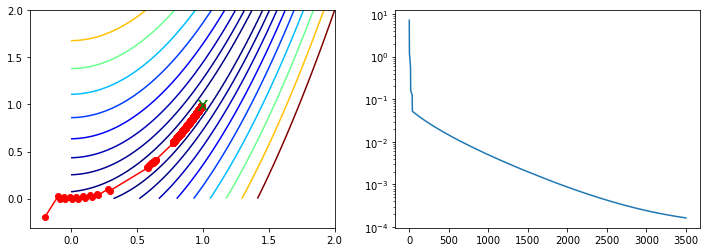

In [11]:
plot_rosen(local_descent, 3500)

### Results
Local descent eventually reaches the minimum but it takes a large number of iterations to get there

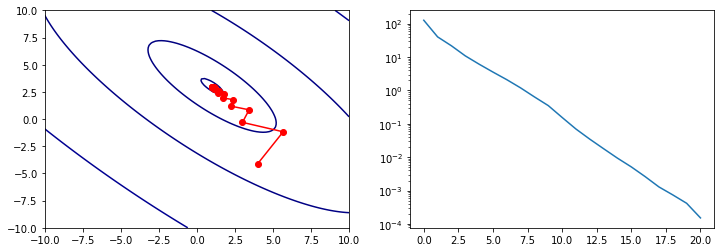

In [12]:
plot_booth(local_descent, 20)

### Results
Local decent on the booth test function took only 20 steps to find the minimum.

## Evaluate Input-Output Behavior using Logistic Regression & Iris Dataset

The algorithms output for log loss is 9.992007221626413e-16
Accuracy 1.0 compared to Sklearn 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion Matrix Values
[[50  0]
 [ 0 50]]
Stratified KFold Cross Validation
AUC Analysis


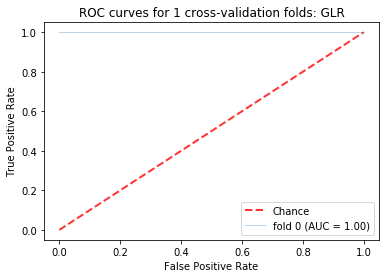

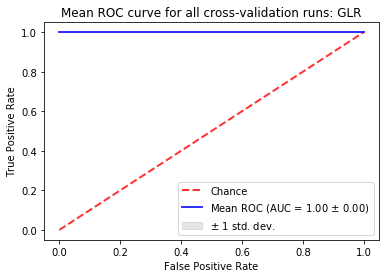

In [13]:
params = {
    'α':0.01,
    'steps':300,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}


θ_init = np.zeros((X.shape[1],1))
T_GLR_LD = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD, X, y, local_descent, params)
m_val.fit()
evaluate_lr(m_val)

### Results
As we've seen in task A, only clearly linearly separable data the logistic regression class, with local descent as the optimizer performs really well.
* Log Loss is near zero
* Accuracy is 100%
* Precision, recall and F1 scores are all 1
* Confusion matrix shows zero mis-classifications
* Verified by cross validation and ROC plots

## Evaluate Input-Output Behavior using Logistic Regression & Wine Dataset

The algorithms output for log loss is 2.4177383355666544
Accuracy 0.93 compared to Sklearn 0.98
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        59
           1       0.93      0.90      0.91        41

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Confusion Matrix Values
[[56  3]
 [ 4 37]]
Stratified KFold Cross Validation
AUC Analysis


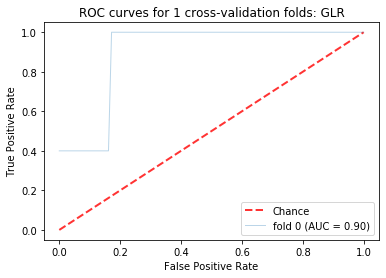

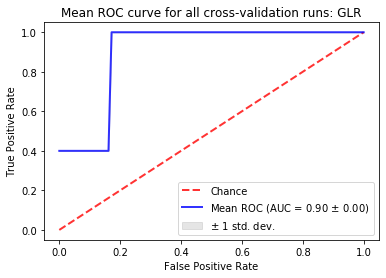

In [14]:
params = {
    'α':0.01,
    'steps':15000,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}


θ_init = np.zeros((X_w.shape[1],1))
T_GLR_LD_1 = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD_1, X_w, y_w, local_descent, params)
m_val.fit()
evaluate_lr(m_val)

### Results
The wine data set does not have such a clear boundary between the classes. As such we have seen some inaccuracy creep in. 
* Log Loss is 2.4, still quite low
* Accuracy is around 93% compared to 98% from SKLearn
    * Required a high number of iterations to get this result
* Precision, recall and F1 scores are all in the 90% range
* Confusion matrix shows some mis-classifications
    * False Positives: 3
    * False Negatives: 4
* Verified by cross validation and ROC plots
* Overall still a good result

## Evaluate Input-Output Behavior using Logistic Regression & Breast Cancer Dataset

The algorithms output for log loss is 2.7631260995157616
Accuracy 0.92 compared to Sklearn 0.96
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        65
           1       0.91      0.86      0.88        35

    accuracy                           0.92       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.92      0.92       100

Confusion Matrix Values
[[62  3]
 [ 5 30]]
Stratified KFold Cross Validation
AUC Analysis


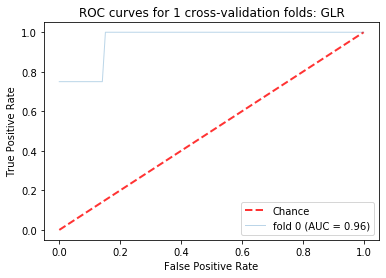

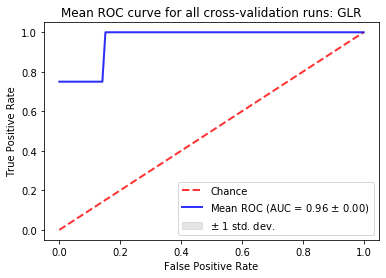

In [15]:
params = {
    'α':0.01,
    'steps':15000,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}

θ_init = np.zeros((X_b.shape[1],1))
T_GLR_LD_2 = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD_2, X_b, y_b, local_descent, params)
m_val.fit()
evaluate_lr(m_val)

### Results
The breast cancer data also set does not have such a clear boundary between the classes. 
* Log Loss is 2.7, tracking similarly to the wine dataset
* Accuracy is around 92% compared to 96% from SKLearn
    * Required a high number of iterations to get this result
* Precision, recall and F1 scores are worse in terms of recall
    * Still at high 80% range
* Confusion matrix shows some mis-classifications
    * False Positives: 3
    * False Negatives: 5
* Verified by cross validation and ROC plots
* Overall still a good result, the results line up with the wine dataset which shows consistency in the implementation. 

# Optimisation Algorithms
## Adagrad
Adagrad is an adaptive gradient algorithm which adapts the learning rate to the parameters. Adagrad allows us to decay the learning rate based on the history of how frequently a feature occurs. It will apply lower learning rate for parameters associated with features which occur more frequently and higher learning rates for features which occur less frequently. 

In [16]:
def adagrad(θ0, cost, gradient, steps=100, α=0.1, β=0.0, ϵ_x= 1e-8, ϵ_d=1e-8, plotting=False):
    Tmp = [θ0]
    s = np.zeros((θ0.shape[0],1))
    for iteration in range(steps):
        g = gradient(θ0)
        if np.linalg.norm(g) < ϵ_d:
            print("Gradient norm below threshold")
            break
        
        #adagrad
        s[:] += g**2
        θ1 = θ0 - α*g /(np.sqrt(s) + ϵ_x)
        
        if np.linalg.norm(θ1-θ0)<ϵ_x:
            print("Step Tolerance below threshold")
            break
        θ0 = θ1
        Tmp.append(θ1)
    return np.array(Tmp)

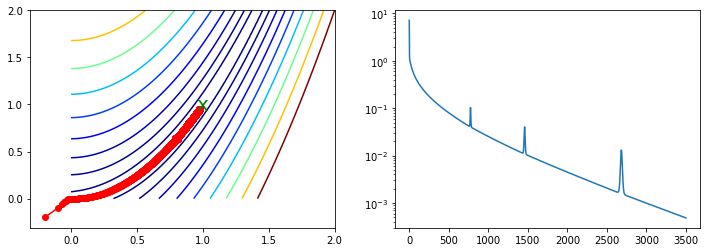

In [17]:
plot_rosen(adagrad, 3500)

### Results
Same as with local descent, adagrad required a large number of iterations before it found the minimum

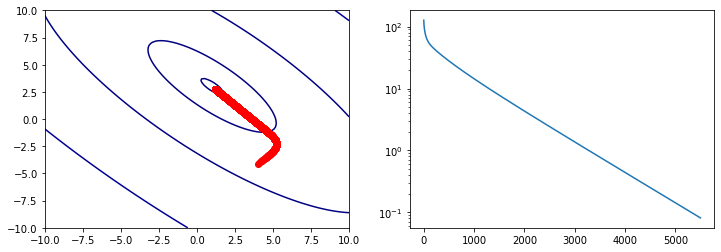

In [18]:
plot_booth(adagrad, 5500)

### Results
Booth required more steps also and did find the minimum

## Evaluate Input-Output Behavior using Logistic Regression & Iris Dataset

The algorithms output for log loss is 9.992007221626413e-16
Accuracy 1.0 compared to Sklearn 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion Matrix Values
[[50  0]
 [ 0 50]]
Stratified KFold Cross Validation
AUC Analysis


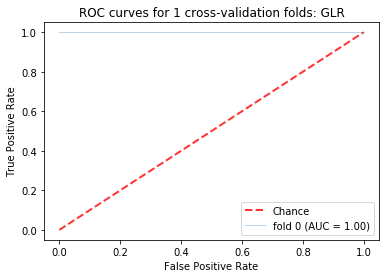

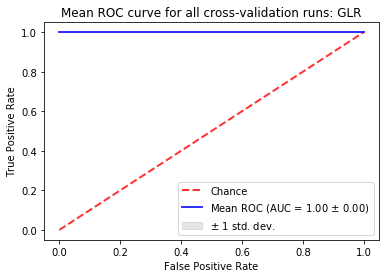

In [19]:
params = {
    'α':0.01,
    'steps':300,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}


θ_init = np.zeros((X.shape[1],1))
T_GLR_LD = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD, X, y, adagrad, params)
m_val.fit()
evaluate_lr(m_val)

### Results
Again, with clearly linearly separable data the logistic regression class, with adagrad as the optimizer performs really well.
* Log Loss is near zero
* Accuracy is 100%
* Precision, recall and F1 scores are all 1
* Confusion matrix shows zero mis-classifications
* Verified by cross validation and ROC plots

## Evaluate Input-Output Behavior using Logistic Regression & Wine Dataset

The algorithms output for log loss is 1.3815670477450317
Accuracy 0.96 compared to Sklearn 0.98
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        59
           1       0.95      0.95      0.95        41

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

Confusion Matrix Values
[[57  2]
 [ 2 39]]
Stratified KFold Cross Validation
AUC Analysis


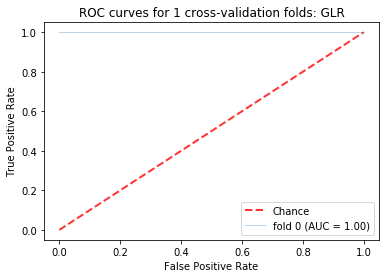

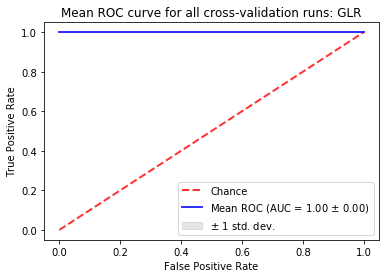

In [20]:
params = {
    'α':0.01,
    'steps':4000,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}

θ_init = np.zeros((X_w.shape[1],1))
T_GLR_LD_1 = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD_1, X_w, y_w, adagrad, params)
m_val.fit()

evaluate_lr(m_val)

### Results
Compared to local descent optimizer we can see an improvement in performance of the input-output behavior
* Log Loss is down to 1.4 compared to 2.4 of local descent
* Accuracy is around 96% compared to 98% from SKLearn. A 2% improvement over local descent
    * Achieved this in 4000 iterations compared to 15000 for local descent
* Precision, recall and F1 scores are all in the 90% range with slight improvements
* Confusion matrix shows some mis-classifications
    * False Positives: 2 down from 3
    * False Negatives: 2 down from 4
* Verified by cross validation and ROC plots
* Performance improvement with less computation - good result

## Evaluate Input-Output Behavior using Logistic Regression & Breast Cancer Dataset

Step Tolerance below threshold
The algorithms output for log loss is 2.07235856759185
Accuracy 0.94 compared to Sklearn 0.96
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        65
           1       0.89      0.94      0.92        35

    accuracy                           0.94       100
   macro avg       0.93      0.94      0.93       100
weighted avg       0.94      0.94      0.94       100

Confusion Matrix Values
[[61  4]
 [ 2 33]]
Stratified KFold Cross Validation
AUC Analysis
Step Tolerance below threshold


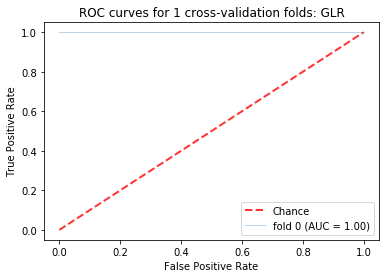

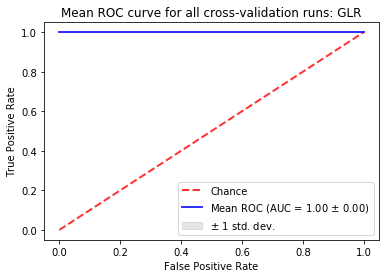

In [21]:
params = {
    'α':0.01,
    'steps':4000,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}

θ_init = np.zeros((X_b.shape[1],1))
T_GLR_LD_2 = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD_2, X_b, y_b, adagrad, params)
m_val.fit()

evaluate_lr(m_val)

### Results
The breast cancer data also set does not have such a clear boundary between the classes. 
* Log Loss is down to 2 which is slightly higher than the wine dataset
* Accuracy is up to 94% compared to 96% from SKLearn
    * Also achieved this on a reduced number of iterations
* Precision, recall and F1 scores are worse in terms of recall
    * All within the 90% range which is an improvement over local descent
* Confusion matrix shows some mis-classifications
    * False Positives: up to 4 from 3
    * False Negatives: down to 2 from 5
* Verified by cross validation and ROC plots
* Still getting a consistent result when compared to the wine dataset, performance improved when compared against local descent

## Adam
Adam (Adaptive Moment Estimation) brings together a number of optimization patterns to improve upon stochastic gradient descent to update weights and biases. It is widely adopted in deep learning scenarios. It boasts (among others) the following properties:
* Easy to implement
* Computationally efficient
* Uses little memory

It incorporates the ability shown in Adagrad & RMSProp where an individual adaptive learning rate is applied to each feature. Adam also calculates the average of the second moments of the gradients. 

In [22]:
def adam(θ0, cost, gradient, steps=100, α=0.1, β=0.0, ϵ_x= 1e-8, ϵ_d=1e-8, plotting=False):
    Tmp = [θ0]
    decay_v = 0.9
    decay_s = 0.999
    v = np.zeros((θ0.shape[0],1))
    s = np.zeros((θ0.shape[0],1))
    t = 0

    for iteration in range(steps):
        g = gradient(θ0)
        if np.linalg.norm(g) < ϵ_d:
            print("Gradient norm below threshold")
            break
        
        #adam
        v[:] = decay_v * v + (1 - decay_v) * g
        s[:] = decay_s * s + (1 - decay_s) * g**2
        t += 1
        
        v_hat = v / (1 - decay_v**t)
        s_hat = s / (1 - decay_s**t)
        
        θ1 = θ0 - α*v_hat / (np.sqrt(s_hat) + ϵ_x)
        
        if np.linalg.norm(θ1-θ0)<ϵ_x:
            print("Step Tolerance below threshold")
            break
        θ0 = θ1
        Tmp.append(θ1)
    return np.array(Tmp)

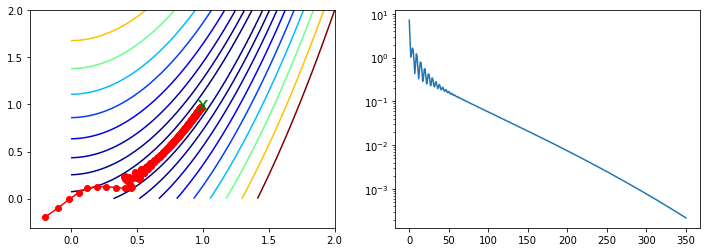

In [23]:
plot_rosen(adam, 350)

### Results
Found the minimum with very few iterations when compared to local descent and adagrad

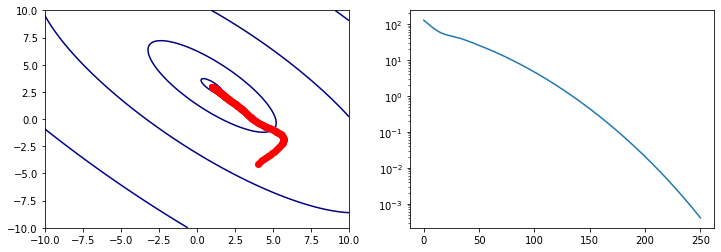

In [24]:
plot_booth(adam, 250)

### Results
Similarly, minimum identified with few iterations required. Shows that Adam is far superior in terms of efficiency

## Evaluate Input-Output Behavior using Logistic Regression & Iris Dataset

The algorithms output for log loss is 9.992007221626413e-16
Accuracy 1.0 compared to Sklearn 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion Matrix Values
[[50  0]
 [ 0 50]]
Stratified KFold Cross Validation
AUC Analysis


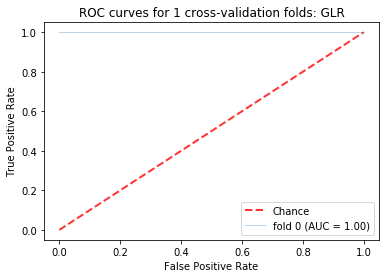

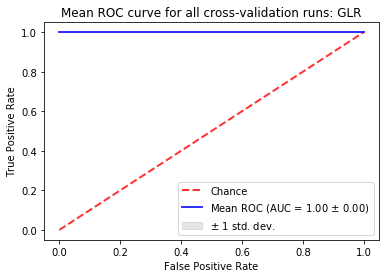

In [25]:
params = {
    'α':0.01,
    'steps':300,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}

θ_init = np.zeros((X.shape[1],1))
T_GLR_LD = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD, X, y, local_descent, params)
m_val.fit()

evaluate_lr(m_val)

### Results
No real surprise here. Clearly separable, performs really well with Adam as the optimizer. 
* Log Loss is near zero
* Accuracy is 100%
* Precision, recall and F1 scores are all 1
* Confusion matrix shows zero mis-classifications
* Verified by cross validation and ROC plots

## Evaluate Input-Output Behavior using Logistic Regression & Wine Dataset

Step Tolerance below threshold
The algorithms output for log loss is 1.0361792837959252
Accuracy 0.97 compared to Sklearn 0.98
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        59
           1       0.95      0.98      0.96        41

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

Confusion Matrix Values
[[57  2]
 [ 1 40]]
Stratified KFold Cross Validation
AUC Analysis
Step Tolerance below threshold


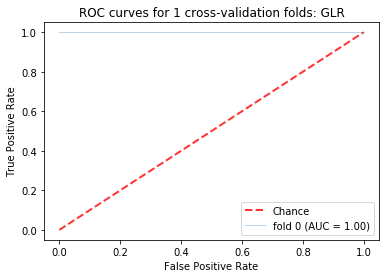

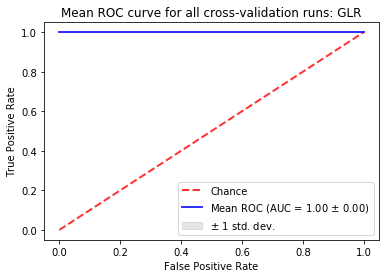

In [26]:
params = {
    'α':0.01,
    'steps':10000,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}

θ_init = np.zeros((X_w.shape[1],1))
T_GLR_LD_1 = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD_1, X_w, y_w, adam, params)
m_val.fit()

evaluate_lr(m_val)

### Results
Compared to local descent optimizer we can see an improvement in performance of the input-output behavior
* Log Loss is down to 1 compared to 2.4 of local descent
* Accuracy is around 97% compared to 98% from SKLearn. A 3% improvement over local descent
    * Achieved this in 10000 iterations compared to 15000 for local descent and 4000 for adagrad
* Precision, recall and F1 scores are all in the high 90% range showing improvement across the board
* Confusion matrix shows some mis-classifications
    * False Positives: 2 down from 3
    * False Negatives: 1 down from 4
* Verified by cross validation and ROC plots
* Performance improvement and near comparable performance to SkLearn

## Evaluate Input-Output Behavior using Logistic Regression & Breast Cancer Dataset

The algorithms output for log loss is 1.0361632918473216
Accuracy 0.97 compared to Sklearn 0.96
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        65
           1       1.00      0.91      0.96        35

    accuracy                           0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100

Confusion Matrix Values
[[65  0]
 [ 3 32]]
Stratified KFold Cross Validation
AUC Analysis


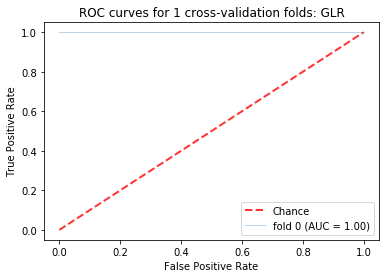

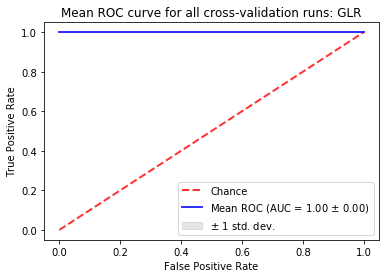

In [27]:
params = {
    'α':0.01,
    'steps':1000,
    'ϵ_x':0.0001,
    'ϵ_d':0.0001
}

θ_init = np.zeros((X_b.shape[1],1))
T_GLR_LD_2 = Generic_LogisticRegression(θ_init, sigmoid, 0.01) 
m_val = Validate_Model(T_GLR_LD_2, X_b, y_b, adam, params)
m_val.fit()

evaluate_lr(m_val)

### Results
Scored equal and above compared to SKLearn using this dataset. 
* Log Loss is down to 1 which is the same as the wine dataset
* Accuracy is up to 97% compared to 96% from SKLearn
    * Also achieved this on only 1000 iterations
* Precision, recall and F1 scores are worse in terms of recall
    * All within the high 90% range which is an improvement over local descent
* Confusion matrix shows some mis-classifications
    * False Positives: down to 0 from 3
    * False Negatives: down to 3 from 5
* Verified by cross validation and ROC plots
* From visually inspecting the data I put this down to the data being slightly more separable compared to the wine dataset. Once again, the model is behaving consistently between the two datasets 

# Conclusions
* Local Descent performed the worst beyond the very separable iris features
    * This was to be expected as we evolved through to Adam
* Began to see a progressive improvement as we moved through the algorithms towards Adam
* Adam had the best score when compared to SKLearn
* Overall the input-output measurements were consistent with no surprises as different optimizers and datasets were used. This shows that both the optimizer functions and logistic regression class are operating correctly